생물학 실험에서 이미지에서 세포 수를 측정 작업은 매우 흔한 일입니다. 일반적으로는 이미지를 촬영하는 장비에 자동으로 세포 수를 측적하는 소프트웨어가 같이 제공되고 있습니다. 그러나 가끔은 수동으로 세포의 수를 측정해야하는 경우가 생기곤 합니다. 그런 작업은 시간과 노력이 많이 들고 결과를 신뢰하기 어렵습니다.

이런 문제를 해결하기 위해 이번 글에서는 오픈소스 컴퓨터 비전 라이브러리인 `OpenCV`를 사용해 이미지를 분석하고 세포 수를 자동으로 측정하는 방법을 소개합니다. `OpenCV`는 강력하고 유연한 이미지 처리 라이브러리이며 세포 수 계수 외에도 다양한 생물학적 이미지 분석에 활용될 수 있습니다.

# 사용된 코드

총 174개 세포 확인.


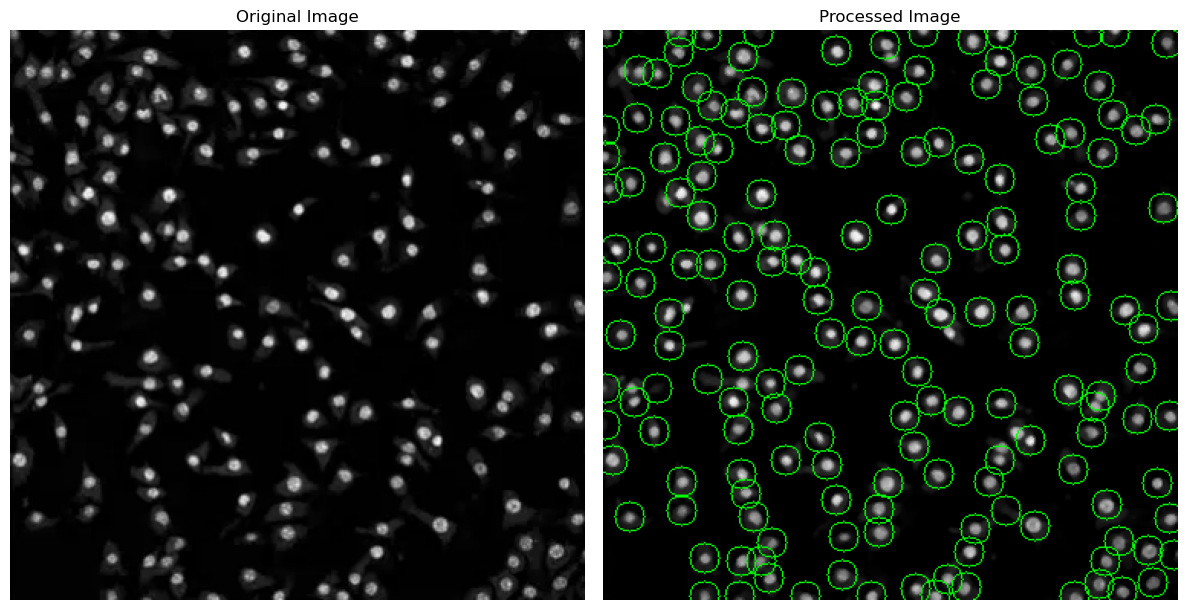

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


def process_image(image_path):
    # 이미지 읽기 및 전처리
    original_im = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # 중간값 필터 적용 (노이즈 제거) 및 배경 추정
    im = cv2.medianBlur(original_im, ksize=3)
    bg = cv2.medianBlur(im, ksize=101)

    # 배경 제거 및 신호 정규화
    signal = cv2.subtract(im, bg)
    signal = cv2.normalize(signal, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # 가우시안 블러 적용 및 마스크 생성
    smooth = cv2.GaussianBlur(signal, (0, 0), sigmaX=2)
    valmask = smooth > 24
    peakmask = smooth == cv2.dilate(smooth, None, iterations=20)

    # 블롭 처리
    blobs = (valmask & peakmask).astype(np.uint8) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    blobs = cv2.morphologyEx(blobs, cv2.MORPH_DILATE, kernel)

    # 연결된 컴포넌트 분석
    nlabels, _, _, centroids = cv2.connectedComponentsWithStats(blobs)

    return original_im, signal, centroids, nlabels - 1


def visualize_results(original, processed, centroids):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.imshow(original, cmap="gray")
    ax1.set_title("Original Image")
    ax1.axis("off")

    ax2.imshow(processed, cmap="gray")
    ax2.set_title("Processed Image")
    ax2.axis("off")

    for pt in centroids[1:]:
        ax2.add_artist(plt.Circle(pt, 20, fill=False, color="lime", linewidth=1))

    plt.tight_layout()
    plt.show()


# 메인 실행 부분
image_path = "../data/input/cell_0.png"
original, processed, centroids, cell_count = process_image(image_path)
print(f"총 {cell_count}개 세포 확인.")
visualize_results(original, processed, centroids)

다른 이미지에 위의 코드를 다시 사용해보겠습니다. 

총 293개 세포 확인.


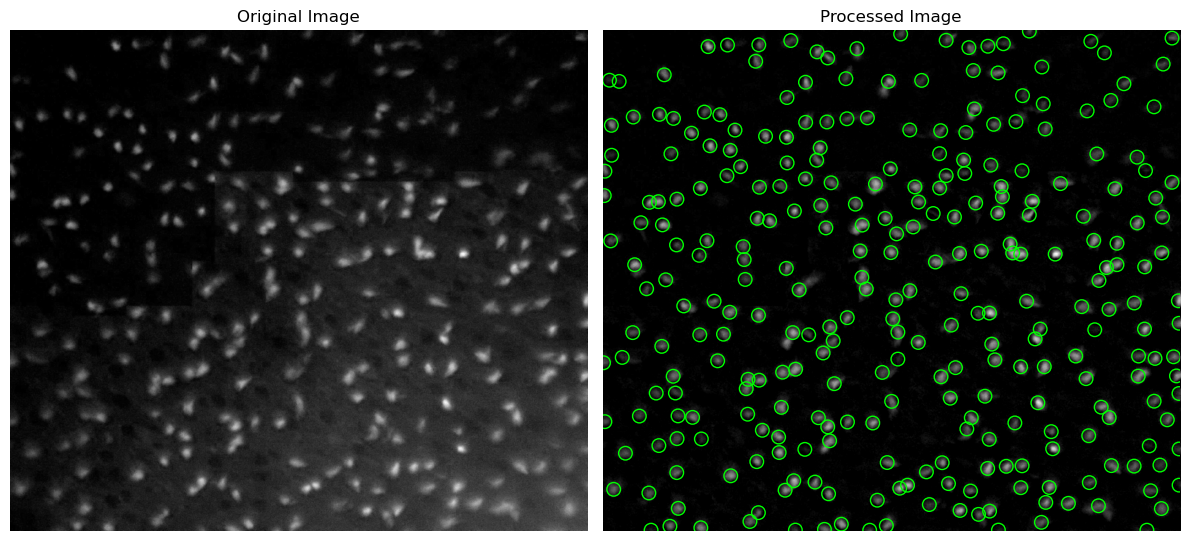

In [ ]:
# 다른 이미지
image_path = "../data/input/cell_2.png"
original, processed, centroids, cell_count = process_image(image_path)
print(f"총 {cell_count}개 세포 확인.")
visualize_results(original, processed, centroids)

이번 글에서는 `OpenCV`를 사용하여 이미지를 분석하고 세포 수를 측정 하는 방법에 대해 설명했습니다. 다만 위에 제시된 방법은 다양한 종류의 세포 이미지에 적용 가능하지 않습니다. 위의 코드는 특정 세포 이미지에 맞춰 최적화된 결과입니다. 따라서 다른 종류의 세포 이미지나 촬영 조건이 다른 이미지에 동일한 코드를 적용할 경우 코드의 파라미터를 조정하거나 전처리 과정을 필요할 수 있습니다.

그러니 더 효율적이고 정확한 세포 수 측정을 위해서는 [NeurIPS 2022 세포 분할 챌린지](https://neurips22-cellseg.grand-challenge.org/) 최종 우승 소프트웨어인 [celldetection](https://github.com/FZJ-INM1-BDA/celldetection)를 사용해보시길 권장합니다.

# Reference

- [이미지 출처](https://stackoverflow.com/questions/72755474/counting-cells-with-opencv)

